# KNN

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import pandas as pd
from joblib import dump, load

In [2]:
SCORINGS = ["roc_auc", "accuracy", "precision", "recall", "f1"]
METRIC = "roc_auc"

def grid_table(grid):
    tabla = pd.DataFrame(grid.cv_results_)
    tabla.sort_values("rank_test_" + METRIC, inplace = True)
    tabla.reset_index(inplace = True)
    cols = ["param_n_neighbors"] + ["mean_test_" + x for x in SCORINGS]
    return tabla[cols]

def metrics_table(model, X, Y):
    predicted = model.predict(X)
    probabilities = model.predict_proba(X)[:,1]
    
    roc_auc = metrics.roc_auc_score(Y, probabilities)
    f1 = metrics.f1_score(Y, predicted)
    acc = metrics.accuracy_score(Y, predicted)
    rec = metrics.recall_score(Y, predicted)
    prec = metrics.precision_score(Y, predicted)
    return pd.DataFrame.from_dict({
        "AUC-ROC": [roc_auc], "Accuracy": [acc], "Precision": [prec], "Recall": [rec], "F1 Score": [f1]
    })

## Modelo con pesos uniformes

Vamos a hacer un Grid Search para encontrar el valor óptimo de vecinos a utilizar.

In [3]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")
pipe = iterative_imputer()
pipe = standarizer(pipe)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

In [4]:
# La grid tarda muchísimo en terminar, si se desea se puede cargar de archivo y saltear el próximo bloque
# de código, descomentando la siguiente línea. También se pueden saltear los próximos 3 bloques de código si
# solo se desea ver el modelo final con los parámetros encontrados.
# grid = load('KNN/uniforme_grid.joblib')

In [5]:
X_grid = pipe.fit_transform(X_train)

# Cuidado ejecutando esto que ya con 6 threads consume como 13GB de RAM a momentos y puede morir la compu,
# cualquier cosa bajar el n_jobs a un número más chico (o más grande si tenes +16GB y va a ir más rápido)
grid = GridSearchCV(KNeighborsClassifier(weights='uniform'), param_grid = {'n_neighbors': range(1, 76, 2)},
                    verbose = 1, n_jobs = 6, cv = StratifiedKFold(3), scoring = SCORINGS, refit = METRIC)

grid.fit(X_grid, Y_train.values.ravel())

grid.best_score_

Fitting 3 folds for each of 38 candidates, totalling 114 fits


0.8694025603157335

In [6]:
dump(grid, 'KNN/uniforme_grid.joblib') 

['KNN/uniforme_grid.joblib']

In [12]:
grid_table(grid)

,param_n_neighbors,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,55,0.869403,0.835312,0.794317,0.356121,0.491711
1,47,0.869398,0.836912,0.790530,0.368789,0.502898
2,45,0.869295,0.837169,0.789082,0.371519,0.505136
3,49,0.869283,0.836546,0.791385,0.365840,0.500328
4,53,0.869269,0.835801,0.794926,0.358578,0.494170
5,51,0.869208,0.836192,0.792473,0.362837,0.497713
6,59,0.869189,0.835434,0.800443,0.352299,0.489189
7,57,0.869138,0.835300,0.797487,0.353664,0.489954
8,71,0.869089,0.833187,0.805004,0.335700,0.473766
9,67,0.869081,0.833724,0.803598,0.339849,0.477642


La progresión de los parámetros es interesante en este caso. Podemos ver como los valores más altos de Recall son para cantidad de vecinos más pequeñas, ya que si bien es más sensible a outliers permite a su vez detectar más fácilmente los casos positivos al tener el dataset tiene muchos más casos negativos. Este desbalance provoca que al aumentar la cantidad de vecinos a utilizar aumente las probabilidades de que prediga como negativo, dando como resultado peor recall pero más precision.

Si bien el Recall es pésimo y hay otros parámetros con mejor accuracy, tomando como criterio el ROC-AUC como dice la consigna, el mejor modelo resultó ser el de K=55. Vamos a probar un modelo con todos los datos y ese parámetro:

In [4]:
pipe.steps.append(['knn', KNeighborsClassifier(n_neighbors = 55, weights='uniform')])

pipe.fit(X_train, Y_train.values.ravel())

metrics_table(pipe, X_test, Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.873361,0.837551,0.804983,0.365376,0.502618


Validando con el set de test, el AUC-ROC dio 0.873 (incluso un poco mejor que en el grid) y el accuracy 83,8%. El Recall dio exageradamente bajo por lo explicado previamente.

## Ponderados según la distancia

Vamos a hacer el mismo procedimiento pero con pesos variables tal que la predicción le de más importancia a las instancias más cercanas, a ver si mejora. Como afecta significativamente el modelo, vamos a repetir el Grid Search por si resulta mejor otro valor.

In [3]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")
pipe2 = iterative_imputer()
pipe2 = standarizer(pipe2)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

In [4]:
# La grid tarda muchísimo en terminar, si se desea se puede cargar de archivo y saltear el próximo bloque
# de código, descomentando la siguiente línea. También se pueden saltear los próximos 3 bloques de código si
# solo se desea ver el modelo final con los parámetros encontrados.
# grid2 = load('KNN/ponderado_grid.joblib')

In [9]:
X_grid = pipe2.fit_transform(X_train)

# Cuidado ejecutando esto que ya con 6 threads consume como 13GB de RAM a momentos y puede morir la compu,
# cualquier cosa bajar el n_jobs a un número más chico (o más grande si tenes +16GB y va a ir más rápido)
grid2 = GridSearchCV(KNeighborsClassifier(weights = "distance"), param_grid = {'n_neighbors': range(1, 76, 2)},
                    verbose = 1, n_jobs = 6, cv = StratifiedKFold(3), scoring = SCORINGS, refit = METRIC)

grid2.fit(X_grid, Y_train.values.ravel())

grid2.best_score_

Fitting 3 folds for each of 38 candidates, totalling 114 fits


0.87113215674804

In [10]:
dump(grid2, 'KNN/ponderado_grid.joblib') 

['KNN/ponderado_grid.joblib']

In [5]:
grid_table(grid2)

,param_n_neighbors,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,55,0.871132,0.836509,0.793241,0.364148,0.499103
1,47,0.871070,0.838146,0.790965,0.375888,0.509561
2,53,0.871001,0.836985,0.793343,0.366933,0.501745
3,49,0.870979,0.837914,0.792303,0.373376,0.507528
4,59,0.870966,0.836448,0.798991,0.359397,0.495724
5,45,0.870965,0.838231,0.788498,0.378454,0.511398
6,51,0.870924,0.837682,0.793997,0.370646,0.505328
7,57,0.870911,0.836448,0.795742,0.361855,0.497424
8,71,0.870878,0.834457,0.803125,0.344491,0.482124
9,61,0.870875,0.835727,0.797592,0.356121,0.492347


Los resultados son prácticamente idénticos. Vamos a probar a probar K=55 y distancias ponderadas con el set entero.

In [6]:
pipe2.steps.append(['knn', KNeighborsClassifier(n_neighbors = 55, weights = "distance")])

pipe2.fit(X_train, Y_train.values.ravel())

metrics_table(pipe2, X_test, Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.874642,0.839115,0.804764,0.374728,0.511352


Dio muy levemente mejor. Parece que ese parámetro no afecta mucho al modelo.

## Con otro escalado

Vamos a probar a cambiar el preprocesamiento utilizando un MinMaxScaler en vez de un StandardScaler y entrenando de nuevo este último modelo.

In [8]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")
pipe3 = iterative_imputer()
pipe3 = minmax(pipe3)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

In [9]:
pipe3.steps.append(['knn', KNeighborsClassifier(n_neighbors = 55, weights='distance')])

pipe3.fit(X_train, Y_train.values.ravel())

metrics_table(pipe3, X_test, Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.861237,0.831835,0.791331,0.341453,0.477059


Parece que dio un poco peor, nos vamos a quedar con el StandardScaler.

## Predicción de nuevos datos

In [10]:
initialize_dataset()

df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
df_extra = hashing_trick(df_extra, 24, "barrio")

# El imputer y standarizer ya estan en el pipe

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe2.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,no
2533,no
7270,si
...,...
73456,no
14471,no
106482,no


In [11]:
df_extra_predict.to_csv("predicciones/KNN.csv")

## Predicciones en el holdout

In [22]:
initialize_dataset()

X_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
Y_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(X_holdout, Y_holdout)
viento_trigonometrico(X_holdout)
X_holdout = hashing_trick(X_holdout, 24, "barrio")

# El imputer y standarizer ya estan en el pipe

metrics_table(pipe2, X_holdout, Y_holdout.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.876921,0.834797,0.778535,0.360552,0.492855


El AUC-ROC dio incluso mejor que en el set de validación con el qeu se lo entrenó, lo cual es un poco sorprendente.

### Matriz de confusión

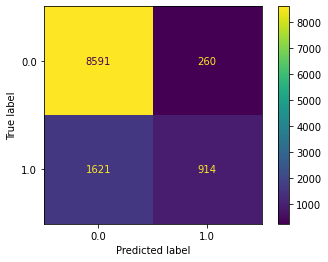

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_holdout, pipe2.predict(X_holdout))
None

En la matriz de confusión podemos ver claramente el problema de haber puesto la cantidad de vecinos tan grande: Tenemos casi el doble de false negatives que de true positives. Es por esto que el Recall es tan bajo.

### Curva ROC

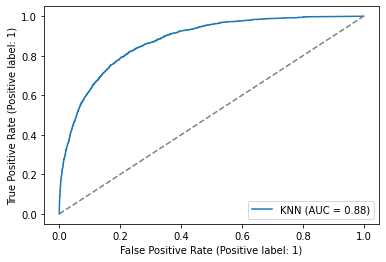

In [25]:
from sklearn.metrics import  RocCurveDisplay
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(Y_holdout, pipe2.predict_proba(X_holdout)[:,1], name = "KNN", ax = ax)
ax.plot([0, 1], [0, 1], "--", color="gray")
plt.show()